# Project CodeNet Program Classification with a TBCNN

This notebook shows an application of a TBCNN for classifying programs by functionality. In this experiment we use Python source code from Project CodeNet and predict their problem_id.

Structure of this notebook:
1. Creation of a derived dataset from Project CodeNet
2. Training of a TBCNN on this dataset
3. Visualizations of the Convolutional Layer of the Model using GraphViz

In [1]:
%load_ext autoreload
%autoreload 2

## Derived Dataset
The derived dataset contains only source code from submissions with status 'Accepted' and programs written in Python 3.4.3. This constraint allows us to parse the code with the built-in Python-module 'ast'.

First, we create an in-memory representation of the CodeNet dataset to retrieve the metadata of all submissions.

In [2]:
from dataset.CodeNet import CodeNet
code_net = CodeNet(location=r"C:\Users\sebas\Documents\Masterarbeit\Project_CodeNet")

In [3]:
submission_metadata = code_net.get_submission_metadata()
submission_metadata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13916868 entries, 0 to 1088
Data columns (total 12 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   submission_id      string
 1   problem_id         string
 2   user_id            string
 3   date               Int64 
 4   language           string
 5   original_language  string
 6   filename_ext       string
 7   status             string
 8   cpu_time           Int64 
 9   memory             Int64 
 10  code_size          Int64 
 11  accuracy           string
dtypes: Int64(4), string(8)
memory usage: 1.4 GB


pandas Dataframes allow us to query and recombine dataframes to construct the derived dataset.

In [4]:
accepted_python3_submissions = submission_metadata.query("original_language == 'Python (3.4.3)' and status == 'Accepted'")

We further use only submissions with more than 2500 submissions, so we have enough data to train on.

In [5]:
python3_submissions_count = accepted_python3_submissions.groupby(["problem_id", "status"]).size().reset_index(name="count").sort_values("count", ascending=False).query("count > 2500")

By merging these two dataframes we get the final derived data we want.

In [6]:
derived_dataset = accepted_python3_submissions.merge(python3_submissions_count, on="problem_id").drop(columns=["status_y"]).rename(columns={"status_x": "status"})

Finally, we use an instance of `ProblemIdClassificationDataset` to manage the dataset on disk. This class offers functionality to create training-, validation- and test-directory with the specified number of samples for each problem. All samples are randomly sampled from the `derived_dataset`

In [11]:
from dataset.ProblemIdClassificationDataset import ProblemIdClassificationDataset

classification_dataset = ProblemIdClassificationDataset(r"C:\Users\sebas\Documents\Masterarbeit\datasets\tbcnn_py3_2500",
                                                 derived_dataset,
                                                 code_net,
                                                 n_train_per_problem=600,
                                                 n_val_per_problem=100,
                                                 n_test_per_problem=300)

The `create_or_load`-method creates an in-memory representation of the classification-dataset or loads it if it already exists in the file system. More specifically, following steps happen during creation:
1. For each `problem_id` in the `derived_dataset` 1000 submissions are sampled (see parameter of Ctor in previous cell).
2. The 1000 samples are split up into train-, validation- and test-partitions according to the parameter in the previous cell. These partitions are represented by dataframes which are serialized with `pickle` for later loading.
3. Each source file is parsed with the `ast` module and a simpler tree in JSON format is created and placed in its respective directory (train, val or test)
4. All encountered AST node types are collected in a map (str->int) and serialized (node_map).
5. All encountered problem_ids (classification labels) are collected and serialized

In [12]:
classification_dataset.create_or_load()

## TBCNN

### Model Creation

In [55]:
from keras.metrics import Precision, Recall
import tensorflow as tf
from classifier.Tbcnn import Tbcnn
node_map = classification_dataset.get_node_map()
labels = classification_dataset.get_labels()
model = Tbcnn(feature_size=len(node_map), conv_output_size=100, num_classes=len(labels))
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer='adam',
              metrics = [tf.keras.metrics.CategoricalAccuracy(), Precision(), Recall()])

### Model Training

In [56]:
from generators.FileStreamDataGenerator import FileStreamDataGenerator

train_files = classification_dataset.get_train_files()
val_files = classification_dataset.get_val_files()
training_generator = FileStreamDataGenerator(train_files, labels, node_map, batch_size=1, shuffle=True)
validation_generator = FileStreamDataGenerator(val_files, labels, node_map, batch_size=1, shuffle=False)
model.fit(training_generator, validation_data=validation_generator, epochs=1)

75600/75600 [==============================] - 170s 2ms/step - loss: 0.6145 - categorical_accuracy: 0.8520 - precision_1: 0.9458 - recall_1: 0.7795 - val_loss: 0.2884 - val_categorical_accuracy: 0.9190 - val_precision_1: 0.9534 - val_recall_1: 0.8934


### Model Evaluation

In [57]:
test_files = classification_dataset.get_test_files()
test_generator = FileStreamDataGenerator(test_files, labels, node_map, batch_size=1, shuffle=False)
y_hat = model.predict(test_generator)
metrics = model.evaluate(test_generator)

37800/37800 [==============================] - 62s 2ms/step - loss: 0.2869 - categorical_accuracy: 0.9181 - precision_1: 0.9522 - recall_1: 0.8944


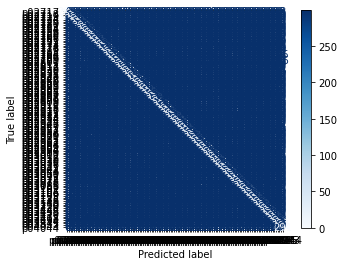

In [60]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from numpy import argmax
from matplotlib import pyplot as plt
labels = list(test_generator.get_label_lookup().keys())
expected_labels = []
predicted_labels = []
for i in range(len(test_generator)):
    _, y = test_generator[i]
    expected_label = labels[argmax(y)]
    predicted_label = labels[argmax(y_hat[i])]
    expected_labels.append(expected_label)
    predicted_labels.append(predicted_label)
cm = confusion_matrix(expected_labels, predicted_labels, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [67]:
from sklearn.metrics import classification_report

print(classification_report(expected_labels, predicted_labels, labels=labels))

              precision    recall  f1-score   support

      p02717       0.98      0.95      0.97       300
      p02718       1.00      0.97      0.98       300
      p02719       0.95      0.95      0.95       300
      p02723       0.88      0.89      0.88       300
      p02724       0.91      0.96      0.93       300
      p02725       0.97      0.93      0.95       300
      p02729       0.85      0.90      0.87       300
      p02730       0.99      0.91      0.95       300
      p02731       0.97      0.96      0.96       300
      p02753       0.64      0.62      0.63       300
      p02754       0.99      0.99      0.99       300
      p02755       0.95      0.99      0.97       300
      p02759       0.93      0.97      0.95       300
      p02760       0.92      0.97      0.94       300
      p02765       1.00      0.99      0.99       300
      p02766       0.92      0.92      0.92       300
      p02767       0.93      0.96      0.94       300
      p02771       0.88    

## Visualization

In [16]:
conv_filter_activations = model.conv_layer(test_generator.__getitem__(1300)[0])

In [17]:
node_importance = model.pooling_layer(conv_filter_activations)[0]

In [18]:
from collections import Counter

node_importance_list = node_importance.numpy().tolist()[0]
counter = Counter(node_importance_list)

In [19]:
import pickle
with open(test_files[1300], 'rb') as f:
    test_sample_ast = pickle.load(f)

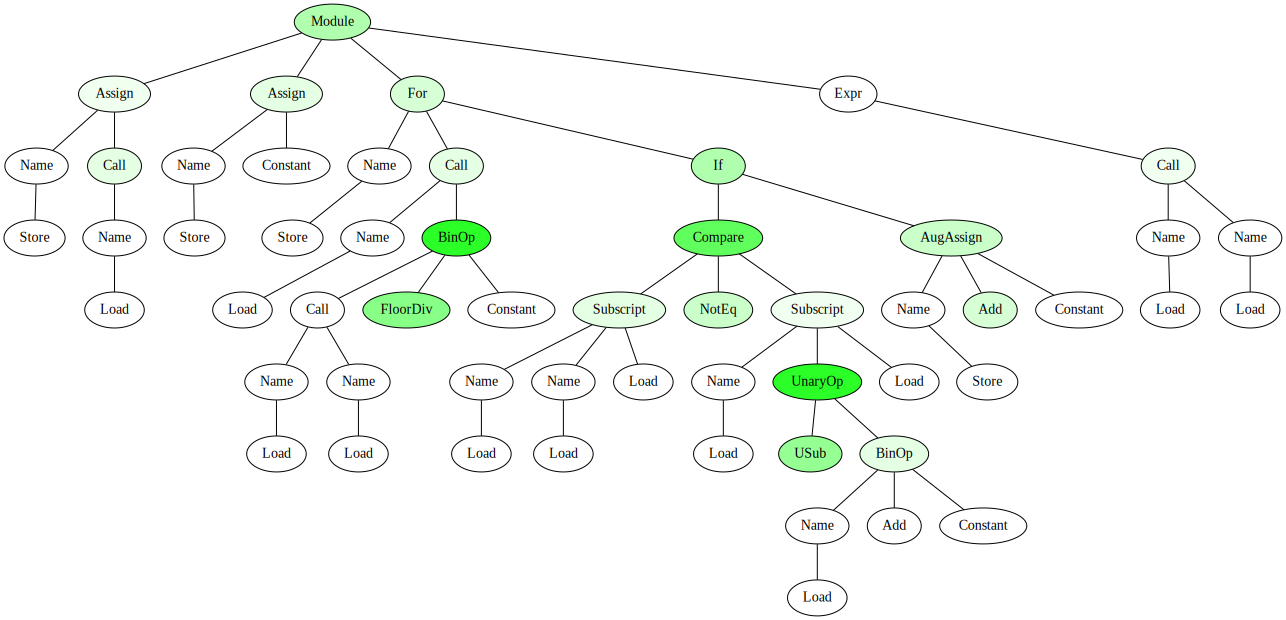

In [20]:
from visualization.GraphvizVisualizer import GraphvizVisualizer

vis = GraphvizVisualizer()
vis.visualizeAst(test_sample_ast, counter)

In [23]:
classification_dataset.get_test_df().iloc[[11167]]

,submission_id,problem_id,user_id,date,language,original_language,filename_ext,status,cpu_time,memory,code_size,accuracy,count
11167,s706812044,p02836,u504562455,1588648856,Python,Python (3.4.3),py,Accepted,19,2940,95,<NA>,2860


In [24]:
code_net.get_src_paths_of_submissions(["s706812044"])

{'s706812044': 'C:\\Users\\sebas\\Documents\\Masterarbeit\\Project_CodeNet\\data\\p02836\\Python\\s706812044.py'}